In [1]:
# import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import KFold

from datetime import datetime

plt.style.use('ggplot')
%matplotlib inline
file_path = '/dataset/eurosat/2750' # path to dataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Setting Data Loading Hyperparameters

In [2]:
# Data Hyperparameters
batch_size=128
validation_split=0.3
seed = 24

In [3]:
# Data Import and Augmentation
train_datagen_non_augmented = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split)

train_datagen_augmented = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=validation_split)

test_datagen = ImageDataGenerator(rescale=1./255,
                                validation_split=validation_split)
# Importing the dataset in original size - also used as data in our base model during our experimentations
train_generator_64x64_non_augmented = train_datagen_non_augmented.flow_from_directory(
        file_path,
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed,
        shuffle=True,
        subset='training')

train_generator_64x64_augmented = train_datagen_augmented.flow_from_directory(
        file_path,
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed,
        shuffle=True,
        subset='training')

test_generator_64x64 = test_datagen.flow_from_directory(
        file_path,
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed,
        shuffle=True,
        subset='validation')
# importing images in upscaled size 224x224
train_generator_224x224_non_augmented = train_datagen_non_augmented.flow_from_directory(
        file_path,
        target_size=(224, 224),
        interpolation='bilinear',
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed,
        shuffle=True,
        subset='training')

train_generator_224x224_augmented = train_datagen_augmented.flow_from_directory(
        file_path,
        target_size=(224, 224),
        interpolation='bilinear',
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed,
        shuffle=True,
        subset='training')

test_generator_224x224 = test_datagen.flow_from_directory(
        file_path,
        target_size=(224, 224),
        interpolation='bilinear',
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed,
        shuffle=True,
        subset='validation')

Found 18900 images belonging to 10 classes.
Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.
Found 18900 images belonging to 10 classes.
Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.


In [4]:
# Print the number of images in train and test data, also the number of classes
n_train = train_generator_64x64_non_augmented.n
n_test = test_generator_64x64.n
print('Number of images in train data =', n_train)
print('Number of images in test data =', n_test)
print('Number of classes = ', train_generator_64x64_non_augmented.num_classes)

Number of images in train data = 18900
Number of images in test data = 8100
Number of classes =  10


In [5]:
print("Names of the classes and their indices: \n")
display(train_generator_64x64_non_augmented.class_indices)

Names of the classes and their indices: 



{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

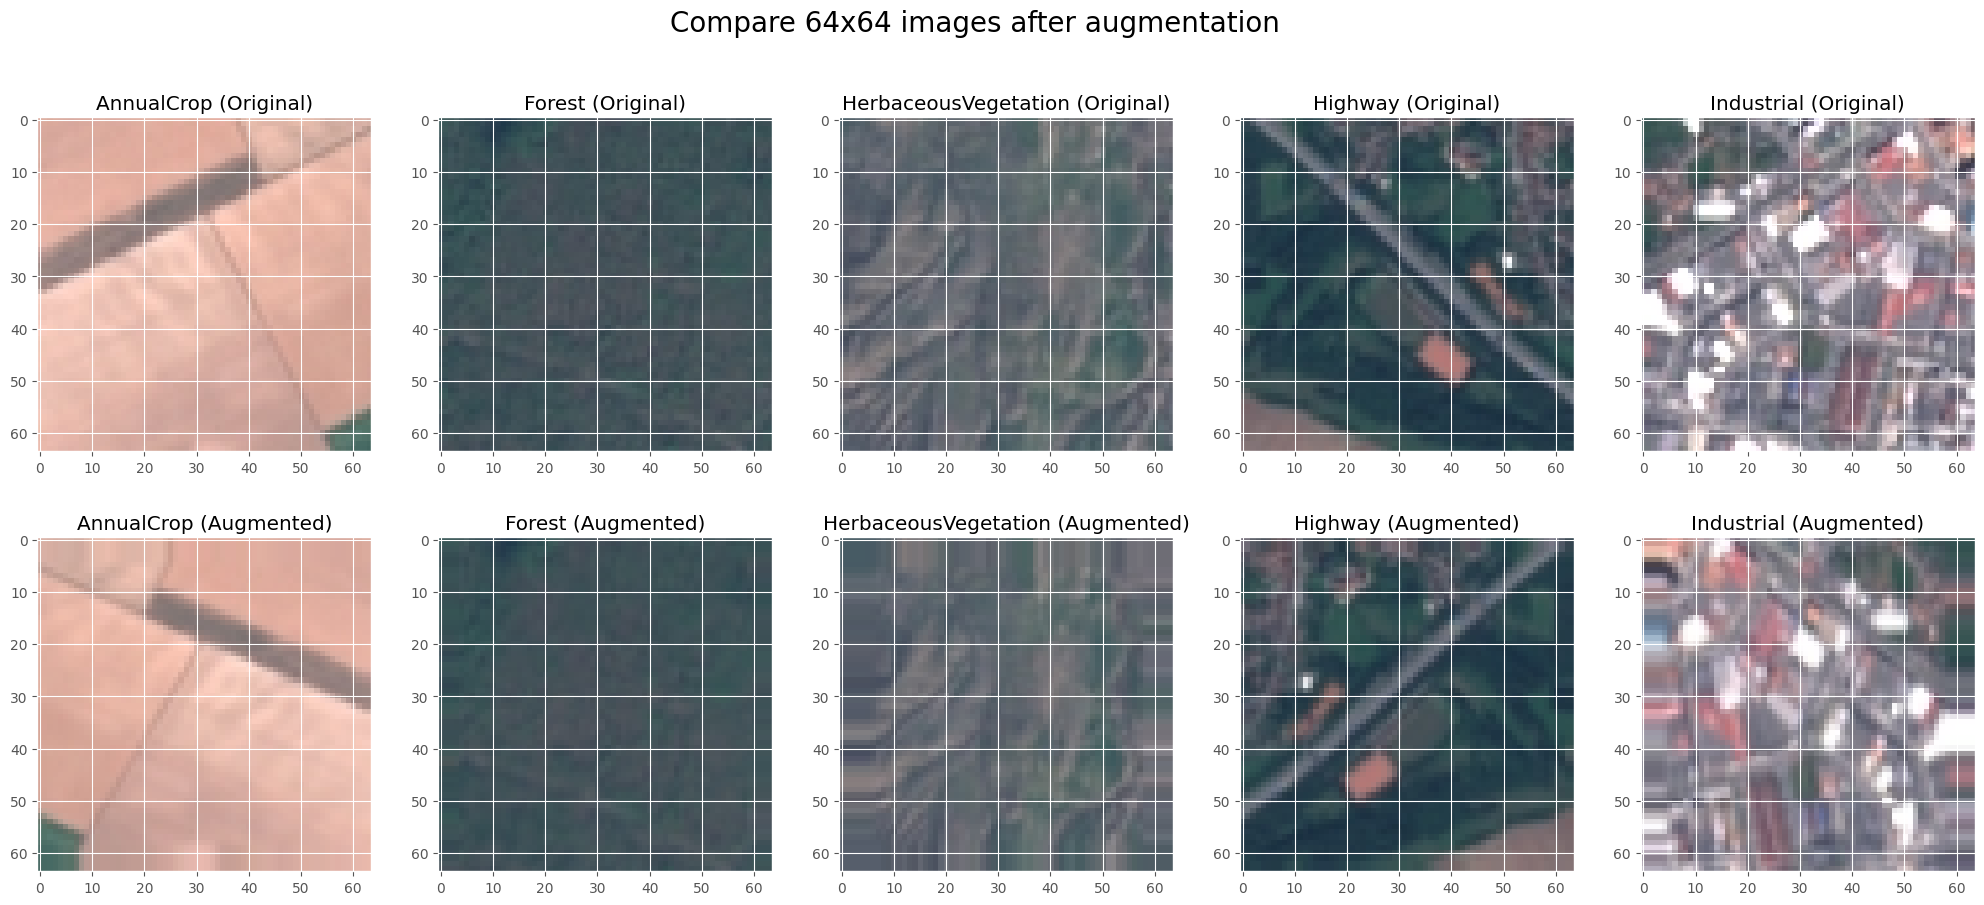

In [6]:
# Plot sample images from the dataset in original size and compare them with the images after augmentation
indices = {v: k for k, v in train_generator_64x64_non_augmented.class_indices.items()}

# Set the number of rows and columns
n_rows = 2
n_cols = 5

# Create a grid for subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*5, n_rows*5))

fig.suptitle("Compare 64x64 images after augmentation", fontsize=20)

for i in range(0, 5):
    for j in range(len(train_generator_64x64_non_augmented[0][0])):
        if (np.where(train_generator_64x64_non_augmented[0][1][j]==1)[0][0])== i:
            ax = axes.flatten()[i]
            ax.imshow(train_generator_64x64_non_augmented[0][0][j])
            ax.set_title(indices[i]+' (Original)')
            ax = axes.flatten()[i+5]
            ax.imshow(train_generator_64x64_augmented[0][0][j])
            ax.set_title(indices[i]+' (Augmented)')
            break
plt.show()

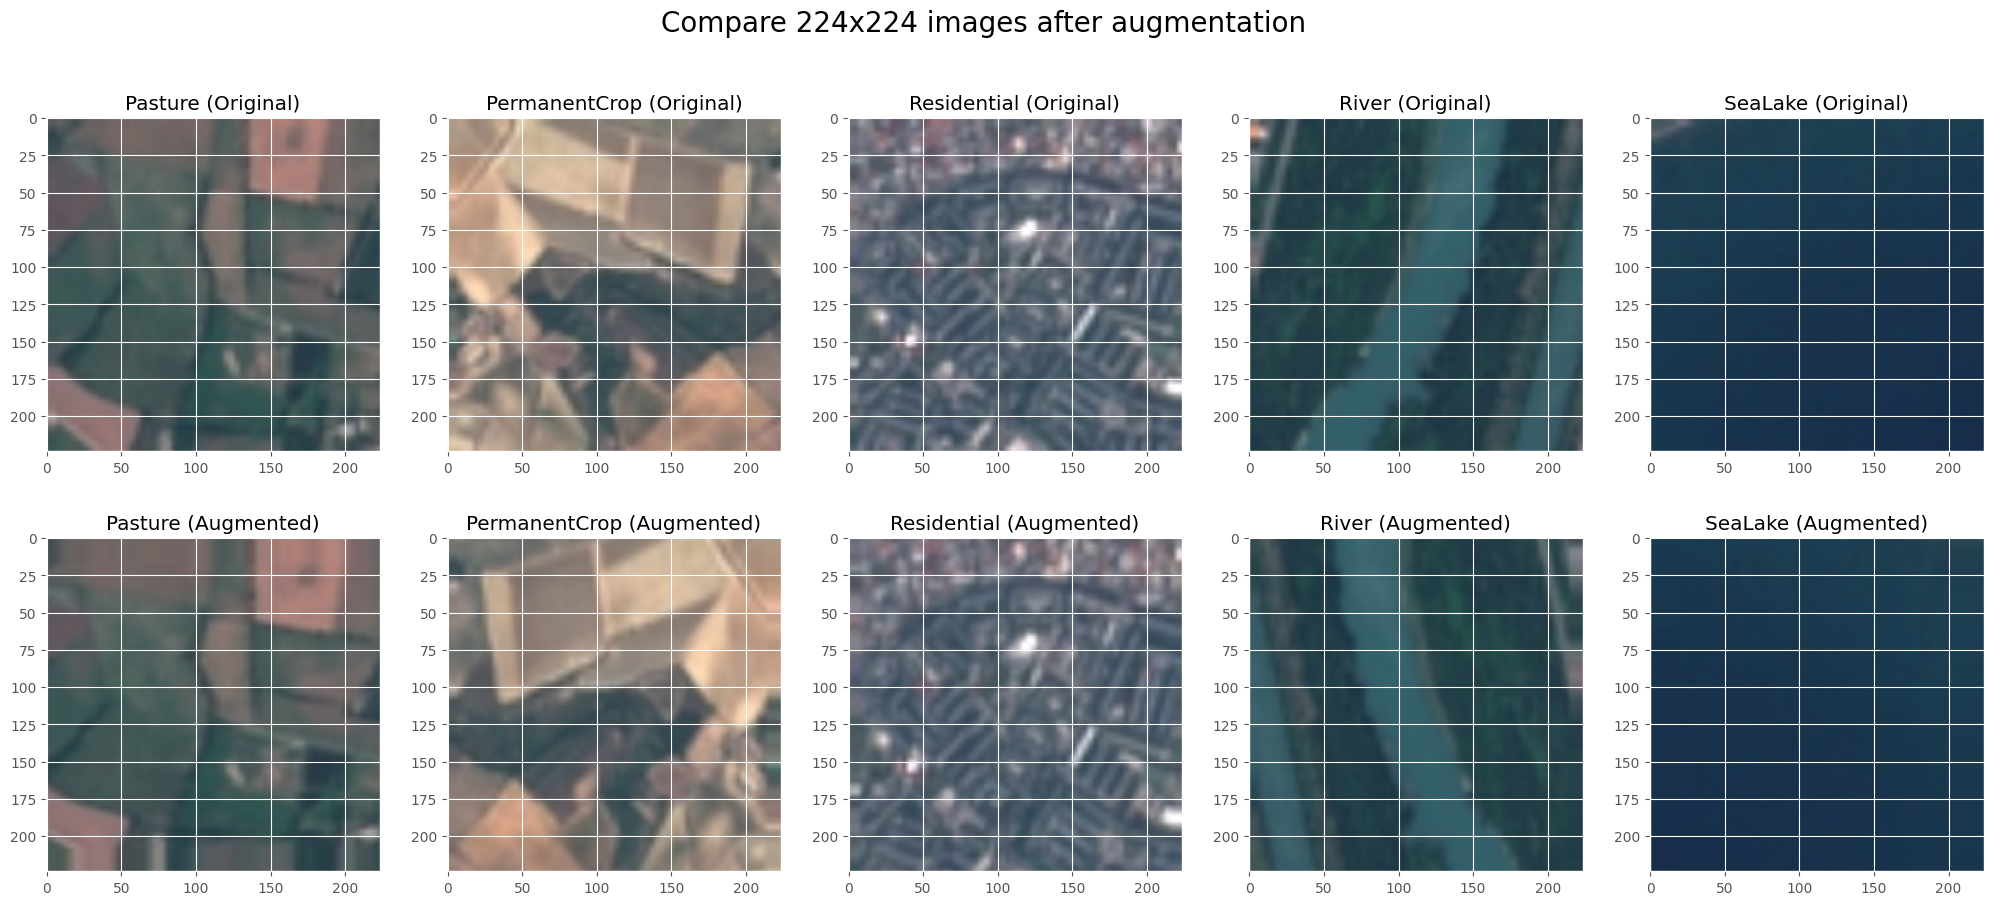

In [7]:
# Plot sample images from the dataset in up-scaled size and compare them with the images after augmentation
indices = {v: k for k, v in train_generator_224x224_non_augmented.class_indices.items()}

# Set the number of rows and columns
n_rows = 2
n_cols = 5

# Create a grid for subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*5, n_rows*5))

fig.suptitle("Compare 224x224 images after augmentation", fontsize=20)

for i in range(5, 10):
    for j in range(len(train_generator_224x224_non_augmented[0][0])):
        if (np.where(train_generator_224x224_non_augmented[0][1][j]==1)[0][0])== i:
            ax = axes.flatten()[i-5]
            ax.imshow(train_generator_224x224_non_augmented[0][0][j])
            ax.set_title(indices[i]+' (Original)')
            ax = axes.flatten()[i]
            ax.imshow(train_generator_224x224_augmented[0][0][j])
            ax.set_title(indices[i]+' (Augmented)')
            break
plt.show()

Text(0.5, 1.0, 'Distribution of data between classes before image augmentation')

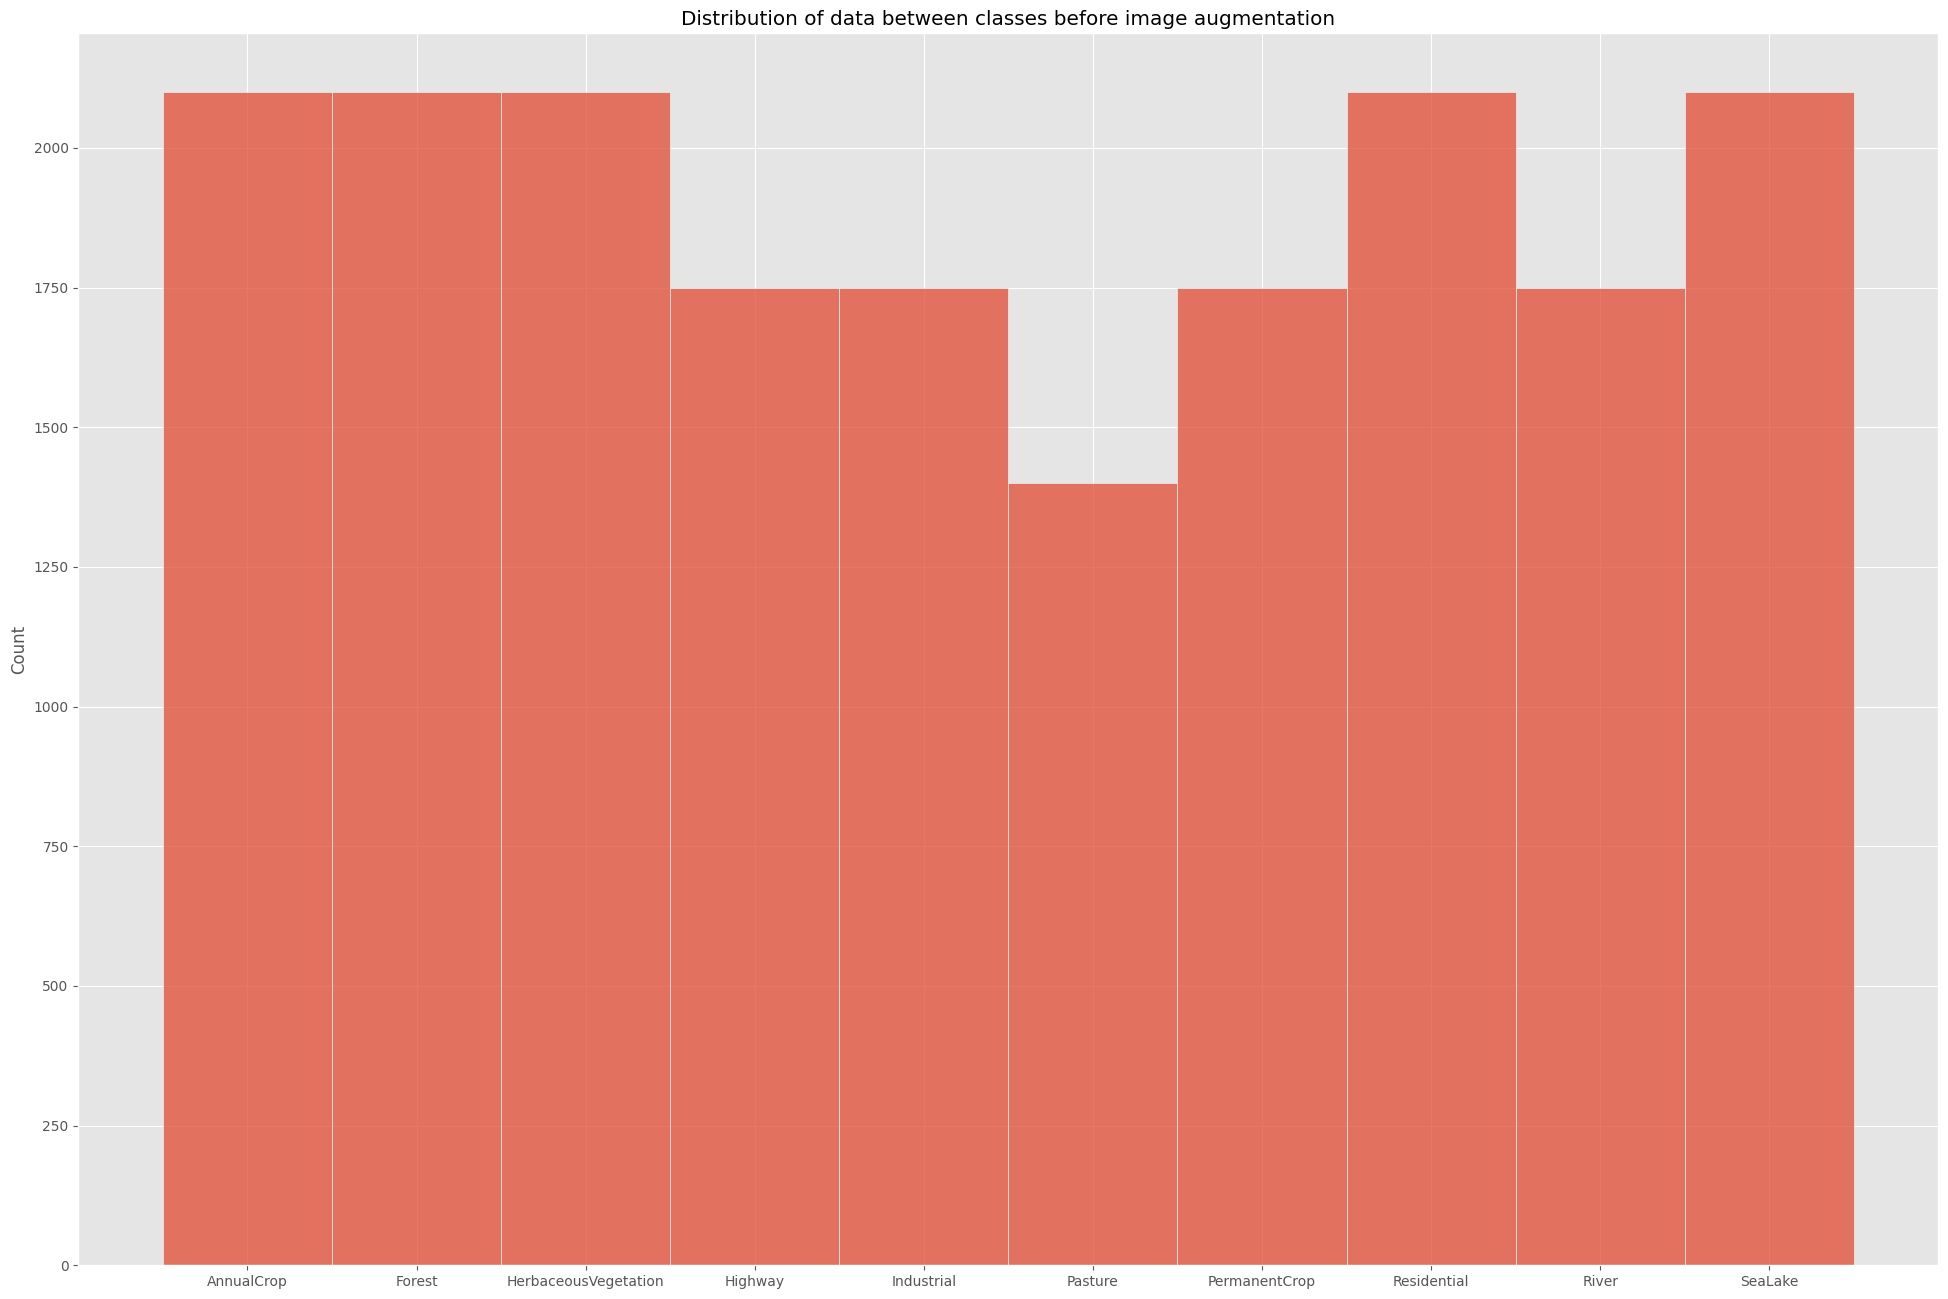

In [8]:
# Plot the distribution of data between classes before image augmentation
labels = [indices[label] for label in train_generator_64x64_non_augmented.labels]
plt.figure(figsize=(24,16))
sns.histplot(labels, bins=train_generator_64x64_non_augmented.num_classes)
plt.title('Distribution of data between classes before image augmentation')

In [9]:
#Now we want to have a way to combine both augmented and non augmented data (for both sizes of image)
#and have that be fed to train the model to see if there is any difference in performance
#based on image size
#Try to cast both generators to TF Datasets first - then concatenate them - then this dataset can still
#be fed to model.fit when we want to fit our model on the augmented and non-augmented data
#This effectively doubles the training set size but should lead to better generalization

train_64x64_non_augmented_ds = tf.data.Dataset.from_generator(lambda: train_generator_64x64_non_augmented,output_types = (tf.float32, tf.float32),output_shapes=([None,64,64,3],[None,10]))
train_64x64_augmented_ds = tf.data.Dataset.from_generator(lambda: train_generator_64x64_augmented,output_types = (tf.float32, tf.float32),output_shapes=([None,64,64,3],[None,10]))

train_64x64_combo_ds = train_64x64_non_augmented_ds.concatenate(train_64x64_augmented_ds)

#Do a similar thing for 224x224
train_224x224_non_augmented_ds = tf.data.Dataset.from_generator(lambda: train_generator_224x224_non_augmented,output_types = (tf.float32, tf.float32),output_shapes=([None,224,224,3],[None,10]))
train_224x224_augmented_ds = tf.data.Dataset.from_generator(lambda: train_generator_224x224_augmented,output_types = (tf.float32, tf.float32),output_shapes=([None,224,224,3],[None,10]))

train_224x224_combo_ds = train_224x224_non_augmented_ds.concatenate(train_224x224_augmented_ds)


In [10]:
# Helper function to plot the loss and accuracy over the epochs for a list of histories
def acc_loss_plot(history_list, legend_list):
    legend = []
    plt.figure(figsize=(12,8))
    for index, history in enumerate(history_list):
        plt.plot(np.arange(1,n_epochs+1), history.history['accuracy'], color=sns.color_palette()[index])
        plt.plot(np.arange(1,n_epochs+1), history.history['val_accuracy'], linestyle='--', color=sns.color_palette()[index])
        legend.append(legend_list[index] + ' - Train')
        legend.append(legend_list[index] + ' - Validation')
    plt.title('Comparing accuracy over the epochs')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(legend)
    plt.show()
    
    print('\n')
    plt.figure(figsize=(12,8))
    for index, history in enumerate(history_list):
        plt.plot(np.arange(1,n_epochs+1), history.history['loss'], color=sns.color_palette()[index])
        plt.plot(np.arange(1,n_epochs+1), history.history['val_loss'], linestyle='--', color=sns.color_palette()[index])
    plt.title('Comparing loss over the epochs')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim([0.0,3.0])
    plt.legend(legend)
    plt.show()
    

In [11]:
# Function to create layer blocks for ResNet50
def residual_unit(X, f, filters, stage, block, activation, stride=1):
    F1, F2, F3 = filters
    X_shortcut = X

    if stride > 1 or X.shape[3] != F3: # To determine if it is a conv block or identity block
        X = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(stride, stride), name='res' + str(stage) + block + '_branch2a', kernel_initializer=glorot_uniform(seed=0))(X)
    else:
        X = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(stride, stride), padding='valid', name='res' + str(stage) + block + '_branch2a', kernel_initializer=glorot_uniform(seed=0))(X)

    X = layers.BatchNormalization(axis=3, name='bn' + str(stage) + block + '_branch2a')(X)
    X = layers.Activation(activation)(X)

    X = layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name='res' + str(stage) + block + '_branch2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name='bn' + str(stage) + block + '_branch2b')(X)
    X = layers.Activation(activation)(X)

    X = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name='res' + str(stage) + block + '_branch2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name='bn' + str(stage) + block + '_branch2c')(X)

    if stride > 1 or X.shape[3] != X_shortcut.shape[3]: # To determine if it is a conv block or identity block   
        X_shortcut = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(stride, stride), padding='valid', name='res' + str(stage) + block + '_branch1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = layers.BatchNormalization(axis=3, name='bn' + str(stage) + block + '_branch1')(X_shortcut)
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation(activation)(X)

    return X

In [12]:
# Construct the ResNet50 model architecture as per the paper referenced in the report
def resnet50(input_shape=(64, 64, 3), classes=10, activation='relu'):
    X_input = layers.Input(input_shape)
    # Stage 1
    X = layers.ZeroPadding2D((3, 3))(X_input)
    X = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = layers.Activation(activation)(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)
    # Stage 2
    X = residual_unit(X, f=3, filters=[64, 64, 256], stage=2, block='a', activation=activation, stride=1)
    X = residual_unit(X, f=3, filters=[64, 64, 256], stage=2, block='b', activation=activation)
    X = residual_unit(X, f=3, filters=[64, 64, 256], stage=2, block='c', activation=activation)
    # Stage 3
    X = residual_unit(X, f=3, filters=[128, 128, 512], stage=3, block='a', activation=activation, stride=2)
    X = residual_unit(X, f=3, filters=[128, 128, 512], stage=3, block='b', activation=activation)
    X = residual_unit(X, f=3, filters=[128, 128, 512], stage=3, block='c', activation=activation)
    X = residual_unit(X, f=3, filters=[128, 128, 512], stage=3, block='d', activation=activation)
    # Stage 4
    X = residual_unit(X, f=3, filters=[256, 256, 1024], stage=4, block='a', activation=activation, stride=2)
    X = residual_unit(X, f=3, filters=[256, 256, 1024], stage=4, block='b', activation=activation)
    X = residual_unit(X, f=3, filters=[256, 256, 1024], stage=4, block='c', activation=activation)
    X = residual_unit(X, f=3, filters=[256, 256, 1024], stage=4, block='d', activation=activation)
    X = residual_unit(X, f=3, filters=[256, 256, 1024], stage=4, block='e', activation=activation)
    X = residual_unit(X, f=3, filters=[256, 256, 1024], stage=4, block='f', activation=activation)
    # Stage 5
    X = residual_unit(X, f=3, filters=[512, 512, 2048], stage=5, block='a', activation=activation, stride=2)
    X = residual_unit(X, f=3, filters=[512, 512, 2048], stage=5, block='b', activation=activation)
    X = residual_unit(X, f=3, filters=[512, 512, 2048], stage=5, block='c', activation=activation)

    X = layers.AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)
    # Dense layer and output layer
    X = layers.Flatten()(X)
    X = layers.Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)
    # Creating model using keras library
    model = tf.keras.Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

# Setting Model Hyperparameters

In [13]:
# Train Hyperparameters
n_epochs = 20 # Initially we ran the base model for 50 epochs, but due to more number of experiments reduced the number of epoch to 20
steps_per_epoch = (n_train*2)//batch_size # 2x because of data augmentation
validation_steps= n_test//batch_size # 1x because no data augmentation
metrics= ['accuracy', Precision(), Recall()] # List of metrics to track in each epoch

# **Experimenting on Input image size (Original 64x64, Upscaled 224x224)**

> Below is the base model with the original image size of 64x64, with ReLU as activation function, adamax as optimizer and KL Divergence as loss function.

In [14]:
model_64x64 = resnet50(input_shape = (64, 64, 3), classes = 10, activation='relu')
model_64x64.compile(optimizer='adamax', loss='kl_divergence', metrics=metrics)
model_64x64.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1[0][0]']                  
                                                                                           

In [15]:
# Trained the model and saving the history of metrics for plotting
history_64x64 = model_64x64.fit(
    train_64x64_combo_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=n_epochs,
    validation_data = test_generator_64x64,
    validation_steps = validation_steps,
    verbose=1)

Epoch 1/20
295/295 [==============================] - 151s 348ms/step - loss: 0.8534 - accuracy: 0.7065 - precision: 0.7992 - recall: 0.6253 - val_loss: 5.0244 - val_accuracy: 0.1913 - val_precision: 0.2363 - val_recall: 0.1850
Epoch 2/20
295/295 [==============================] - 48s 165ms/step - loss: 0.4665 - accuracy: 0.8384 - precision: 0.8701 - recall: 0.8055 - val_loss: 2.9988 - val_accuracy: 0.4189 - val_precision: 0.4508 - val_recall: 0.3900
Epoch 3/20
295/295 [==============================] - 48s 164ms/step - loss: 0.3418 - accuracy: 0.8808 - precision: 0.9010 - recall: 0.8612 - val_loss: 1.0656 - val_accuracy: 0.6873 - val_precision: 0.7163 - val_recall: 0.6643
Epoch 4/20
295/295 [==============================] - 48s 164ms/step - loss: 0.2546 - accuracy: 0.9123 - precision: 0.9243 - recall: 0.8998 - val_loss: 3.4272 - val_accuracy: 0.4049 - val_precision: 0.4136 - val_recall: 0.3931
Epoch 5/20
295/295 [==============================] - 48s 163ms/step - loss: 0.1949 - accur

In [16]:
acc_64x64 = history_64x64.history['accuracy'][-1]
val_acc_64x64 = history_64x64.history['val_accuracy'][-1]
print('The train accuracy is: {:.3f} and the validation accuracy is: {:.3f}'.format(acc_64x64, val_acc_64x64))

The train accuracy is: 0.987 and the validation accuracy is: 0.642


> Below is a model with the upscaled image size of 224x224, with ReLU as activation function, adamax as optimizer and KL Divergence as loss function.

In [17]:
model_224x224 = resnet50(input_shape = (224, 224, 3), classes = 10, activation='relu')
model_224x224.compile(optimizer='adamax', loss='kl_divergence', metrics= metrics)
# model_224x224.summary()

In [18]:
history_224x224 = model_224x224.fit(
    train_224x224_combo_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=n_epochs,
    validation_data = test_generator_224x224,
    validation_steps = validation_steps,
    verbose=1)

Epoch 1/20
295/295 [==============================] - 256s 718ms/step - loss: 1.8669 - accuracy: 0.6478 - precision: 0.7315 - recall: 0.5664 - val_loss: 3.6612 - val_accuracy: 0.1389 - val_precision: 0.1902 - val_recall: 0.1032
Epoch 2/20
295/295 [==============================] - 204s 694ms/step - loss: 0.5093 - accuracy: 0.8274 - precision: 0.8661 - recall: 0.7886 - val_loss: 1.4622 - val_accuracy: 0.5455 - val_precision: 0.5827 - val_recall: 0.5071
Epoch 3/20
295/295 [==============================] - 204s 693ms/step - loss: 0.3632 - accuracy: 0.8772 - precision: 0.8997 - recall: 0.8557 - val_loss: 1.9674 - val_accuracy: 0.6305 - val_precision: 0.6591 - val_recall: 0.6058
Epoch 4/20
295/295 [==============================] - 205s 694ms/step - loss: 0.2869 - accuracy: 0.9046 - precision: 0.9202 - recall: 0.8903 - val_loss: 0.8647 - val_accuracy: 0.7892 - val_precision: 0.8142 - val_recall: 0.7741
Epoch 5/20
295/295 [==============================] - 205s 695ms/step - loss: 0.2256 - a

In [19]:
acc_224x224 = history_224x224.history['accuracy'][-1]
val_acc_224x224 = history_224x224.history['val_accuracy'][-1]
print('The train accuracy is: {:.3f} and the validation accuracy is: {:.3f}'.format(acc_224x224, val_acc_224x224))

The train accuracy is: 0.999 and the validation accuracy is: 0.860


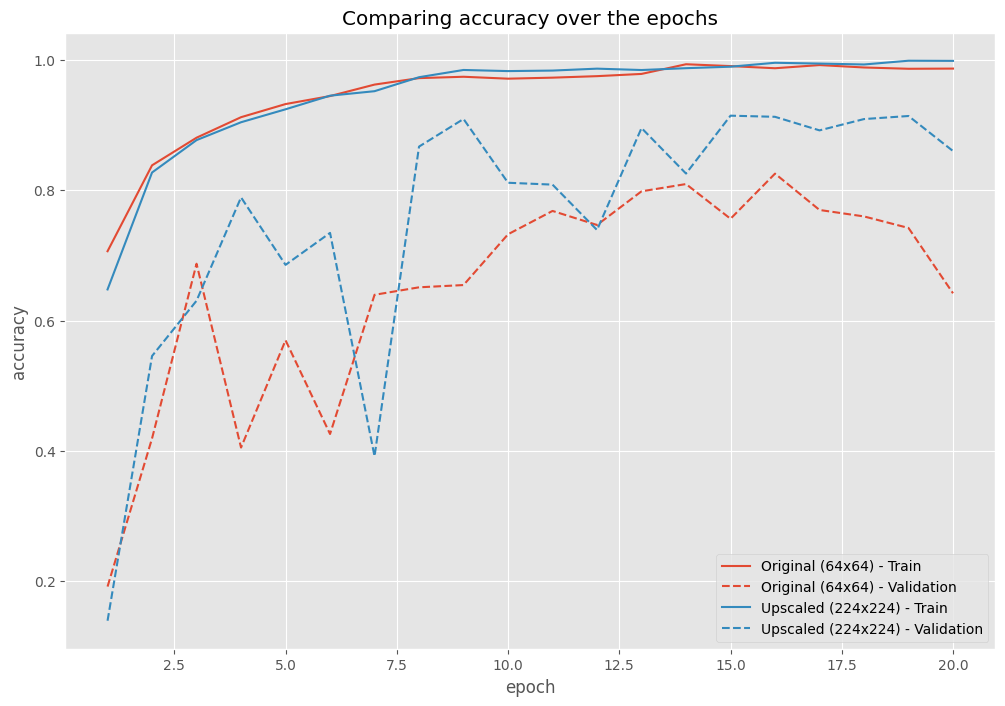

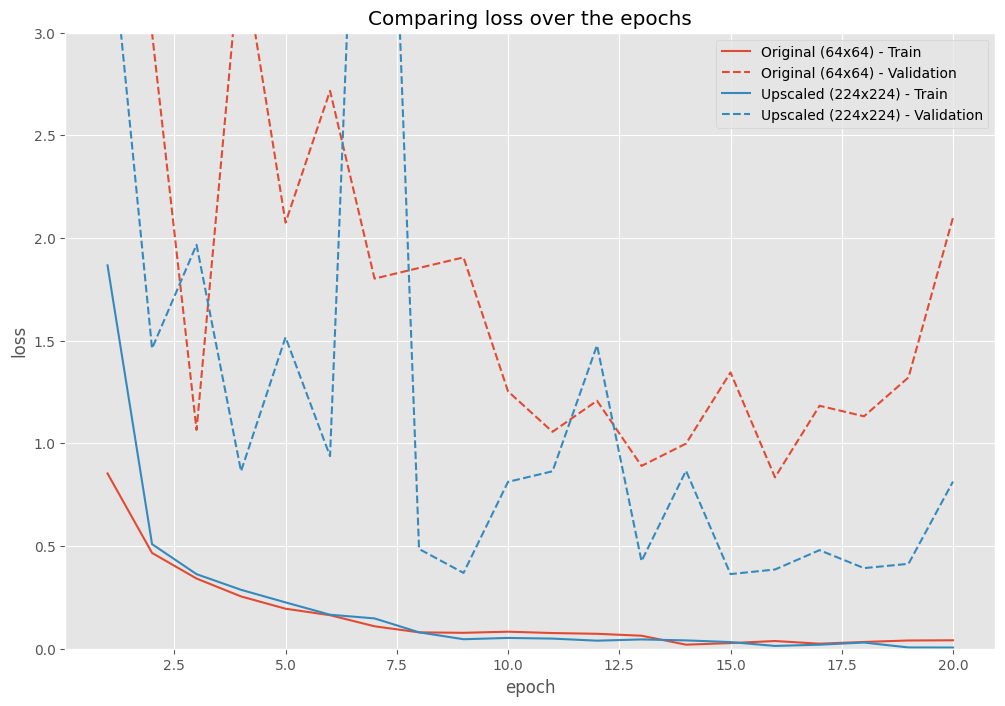

In [20]:
# Plotting the accuracy and loss for both models (64x64 and 224x224) with plot helper function
acc_loss_plot(history_list=[history_64x64, history_224x224], legend_list=['Original (64x64)', 'Upscaled (224x224)'])

## Saving the Model

In [21]:
# Saving the best performing model in .h5 format
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
filename = 'model_64x64' + timestamp + '.h5'
model_64x64.save(filename)

# Saving the best performing model in .h5 format
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
filename = 'model_224x224' + timestamp + '.h5'
model_224x224.save(filename)